02 パラメータの過剰適合の危険性と検証セット
====================================

* 01の結果を見ると、このデータセットに対して97%の精度を持つモデルを見つけた、と言いたくなる

    * しかし、そのような主張は楽観的にすぎる(もしくは間違っている)
    
    * その理由は、以下の通り
    
    * 様々なパラメータを試してそのテストセットに対して最も良い精度が出るものを選んだ
    
    * しかし、この精度は必ずしも新しいデータにも当てはまるわけでは無い
    
    * テストデータをパラメータのチューニングに使ってしまったので、このテストデータをモデルの精度を評価するのには使えない
    
    * これは、データを訓練データとテストセットに分割した理由と同じで、モデルの評価のためには、モデルの構築には用いていない、独立したデータセットが必要

* この問題を解決する方法の1つは、データをもう一度分割し、3つのセットにする方法

    * モデルを構築するセット
    
    * モデルのパラメータを選択するために用いる検証セット(開発セット)
    
    * 選択したパラメータの性能を評価するためのテストセット

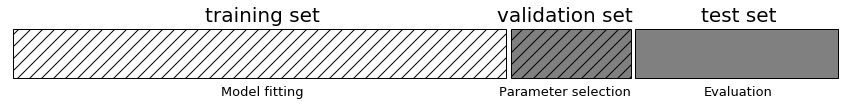

In [1]:
%matplotlib inline
import mglearn
mglearn.plots.plot_threefold_split()

* 検証セットを用いて最良のパラメータを選択したら、そのパラメータを用いてモデルを再構築する

    * この際に、訓練データだけでなく検証データも用いる
    
    * こうすると、可能な限りデータを有効に利用してモデルを構築することができるようになる
    
    * 実装は以下の通りになる

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

iris = load_iris()

# データを訓練+検証セットとテストセットに分割する
X_trainval, X_test, y_trainval, y_test = train_test_split(
    iris.data, iris.target, random_state=0)
# 訓練+検証セットを訓練セットと検証セットに分割する
X_train, X_valid, y_train, y_valid = train_test_split(
    X_trainval, y_trainval, random_state=1)
print("Size of training set: {}   size of validation set: {}   size of test set:"
      " {}\n".format(X_train.shape[0], X_valid.shape[0], X_test.shape[0]))

best_score = 0

for gamma in [0.001, 0.01, 0.1, 1, 10, 100]:
    for C in [0.001, 0.01, 0.1, 1, 10, 100]:
        # それぞれのパラメータの組み合わせに対してSVCを訓練する
        svm = SVC(gamma=gamma, C=C)
        svm.fit(X_train, y_train)
        # SVCを検証セットで評価
        score = svm.score(X_valid, y_valid)
        # 良いスコアだったらスコアとパラメータを保存
        if score > best_score:
            best_score = score
            best_parameters = {'C': C, 'gamma': gamma}

# 訓練セットと検証セットを用いてモデルを再構築し、テストセットで評価
svm = SVC(**best_parameters)
svm.fit(X_trainval, y_trainval)
test_score = svm.score(X_test, y_test)
print("Best score on validation set: {:.2f}".format(best_score))
print("Best parameters: ", best_parameters)
print("Test set score with best parameters: {:.2f}".format(test_score))

Size of training set: 84   size of validation set: 28   size of test set: 38

Best score on validation set: 0.96
Best parameters:  {'C': 10, 'gamma': 0.001}
Test set score with best parameters: 0.92


* 検証セットに対するベストスコアは96%で、先ほどよりも若干低くなっている

    * これはおそらく、モデルの訓練に使えるデータ量が減ったため(データセットを2回分割したので、`X_train`が小さくなっている)
    
    * しかし、テストセットに対するスコア、つまり汎化性能を実際に示すスコアは、さらに低く92%となっている
    
    * したがって、新しいデータに対する精度として主張できるのは、97%ではなく92%ということになる

* 訓練セット、検証セット、テストセットを区別することは機械学習を実運用する上で根本的に重要なことである

    * テストセットの精度に基づいて何らかの選択をすることは、テストセットからモデルへの情報が「漏洩する」ことになる
    
    * したがって、テストセットを分離しておき、最後の評価にだけ用いるようにしなければならない

* 全ての探索的な解析とモデル選択を訓練セットと検証セットだけで行い、テストセットは最後の評価にとっておくと良い

    * 探査的可視化だけの場合でもこれは重要
    
    * 厳密に言えば、テストセットで2つ以上のモデルで評価して良い方を選ぶだけでも、モデルの精度を楽観的に見積もりすぎることになる

|　　版　　|　　　　年/月/日　　　|
|------|----------------|
|初版|2019/03/24|